In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Connecting to Postgres¶
In order to set up the PostGres Database, we used docker-compose to build the jupyter and postgres containers. However, we run into the issue with data persistence as when the PostGres container goes down, the data within that container gets removed. And so we need to create a volume that houses all our data so that whenever our container goes down, the volume will hold all of it. And when the container comes back up, the volume will be operating in the container.

The diagram below shows the setup for this. Also running is our Jupyter notebook container for which this current notebook is running on.

![postgres_setup](https://raw.githubusercontent.com/michaelkim9/nba_predictor_project/master/other_assets/docker_postgres_setup.PNG)

In [3]:
!pip install psycopg2

    100% |████████████████████████████████| 2.6MB 480kB/s ta 0:00:011
You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [7]:
import psycopg2 as pg2
from psycopg2.extras import RealDictCursor

def execute_query(query):  
    connection = pg2.connect(host='postgres',
                             user='postgres',
                             database='basketball')
    cursor = connection.cursor(cursor_factory=RealDictCursor)
    cursor.execute(query)
    r = cursor.fetchall()
    cursor.close()
    return r

def query_to_df(query):
    df = pd.DataFrame(execute_query(query))
    return df

### EDA on Salary Cap

Going to take a look at the salary cap. Exploring this data to develop a problem statement. Knowing from recent events, NBA players' salaries have come under heavy scrutiny and it has become such a topic of dispute that it led to several NBA lockouts. Based on the data, it looks like the amount of money spent on NBA players has grown explosively - just based on salary cap alone.

In [8]:
salary_df = query_to_df('SELECT * FROM salary_cap;')

In [9]:
salary_df.head()

,salary_cap,salary_cap_2015_worth,year
0,3600000.0,7934034.0,1984-85
1,4233000.0,9153509.0,1985-86
2,4945000.0,10317292.0,1986-87
3,6164000.0,12354015.0,1987-88
4,7232000.0,13829137.0,1988-89


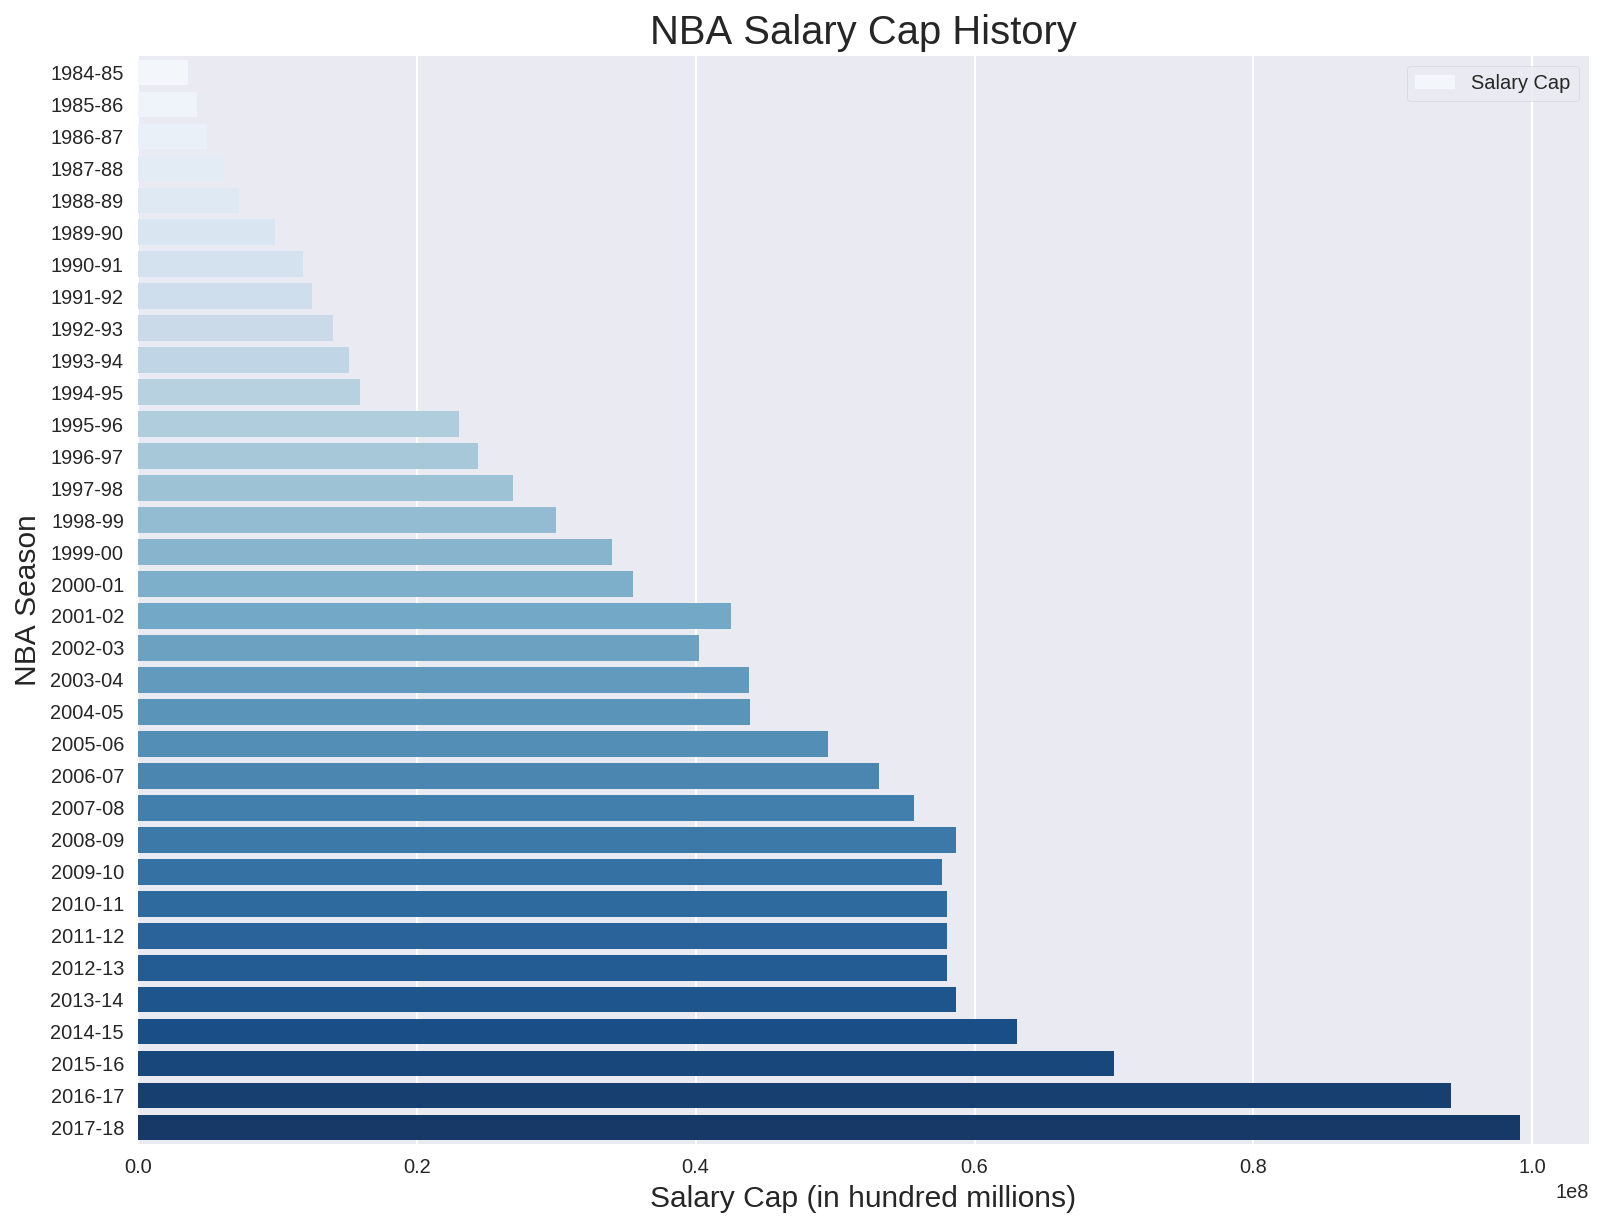

In [10]:
fig = plt.figure(figsize=(13,10)) 
ax = plt.gca()

sns.barplot(x='salary_cap', y='year', data=salary_df, label='Salary Cap',palette='Blues')

ax.set_title('NBA Salary Cap History',size=20)
ax.set_ylabel('NBA Season', fontsize=15)
ax.set_xlabel('Salary Cap (in hundred millions)', fontsize=15)

ax.legend(loc="upper right", frameon=True)
sns.despine(left=True, bottom=True)

### EDA on NBA Team Salaries

Exploring the data of how much money teams spend. Even though there is a salary cap, this is considered a "soft cap" in which it is a complex system of rules and exceptions. Many teams use these exceptions to be able to pay out players even more and allow teams to go beyond the already increasing desiganted salary cap. Gathering salaries for every player in the NBA and grouping them by team, let's see how much the payout is by team and how that compares to the salary cap.

In [11]:
team_sal_df = query_to_df('SELECT * FROM team_salary;')
team_sal_df.head()

,guaranteed,player,signed_using,team,year_five,year_four,year_one,year_three,year_two,year_zero
0,33285709.0,LeBron James,Early Bird,CLE,0.0,0.0,35607968.0,0.0,0.0,33285709.0
1,46761375.0,Kevin Love,Bird Rights,CLE,0.0,0.0,24119025.0,0.0,25595700.0,22642350.0
2,52408695.0,Tristan Thompson,Bird Rights,CLE,0.0,0.0,17469565.0,0.0,18539130.0,16400000.0
3,32350000.0,J.R. Smith,Bird Rights,CLE,0.0,0.0,14720000.0,0.0,15680000.0,13760000.0
4,10337079.0,Iman Shumpert,Bird Rights,CLE,0.0,0.0,11011234.0,0.0,0.0,10337079.0


In [12]:
team_sal_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 514 entries, 0 to 513
Data columns (total 10 columns):
guaranteed      514 non-null float64
player          514 non-null object
signed_using    514 non-null object
team            514 non-null object
year_five       514 non-null float64
year_four       514 non-null float64
year_one        514 non-null float64
year_three      514 non-null float64
year_two        514 non-null float64
year_zero       514 non-null float64
dtypes: float64(7), object(3)
memory usage: 40.2+ KB


In [13]:
team_total = team_sal_df[['team','year_zero']].groupby('team').sum()
team_total.reset_index(inplace=True)
team_total.head()

,team,year_zero
0,ATL,94963111.0
1,BOS,111558063.0
2,BRK,95643736.0
3,CHI,78417155.0
4,CHO,118947949.0


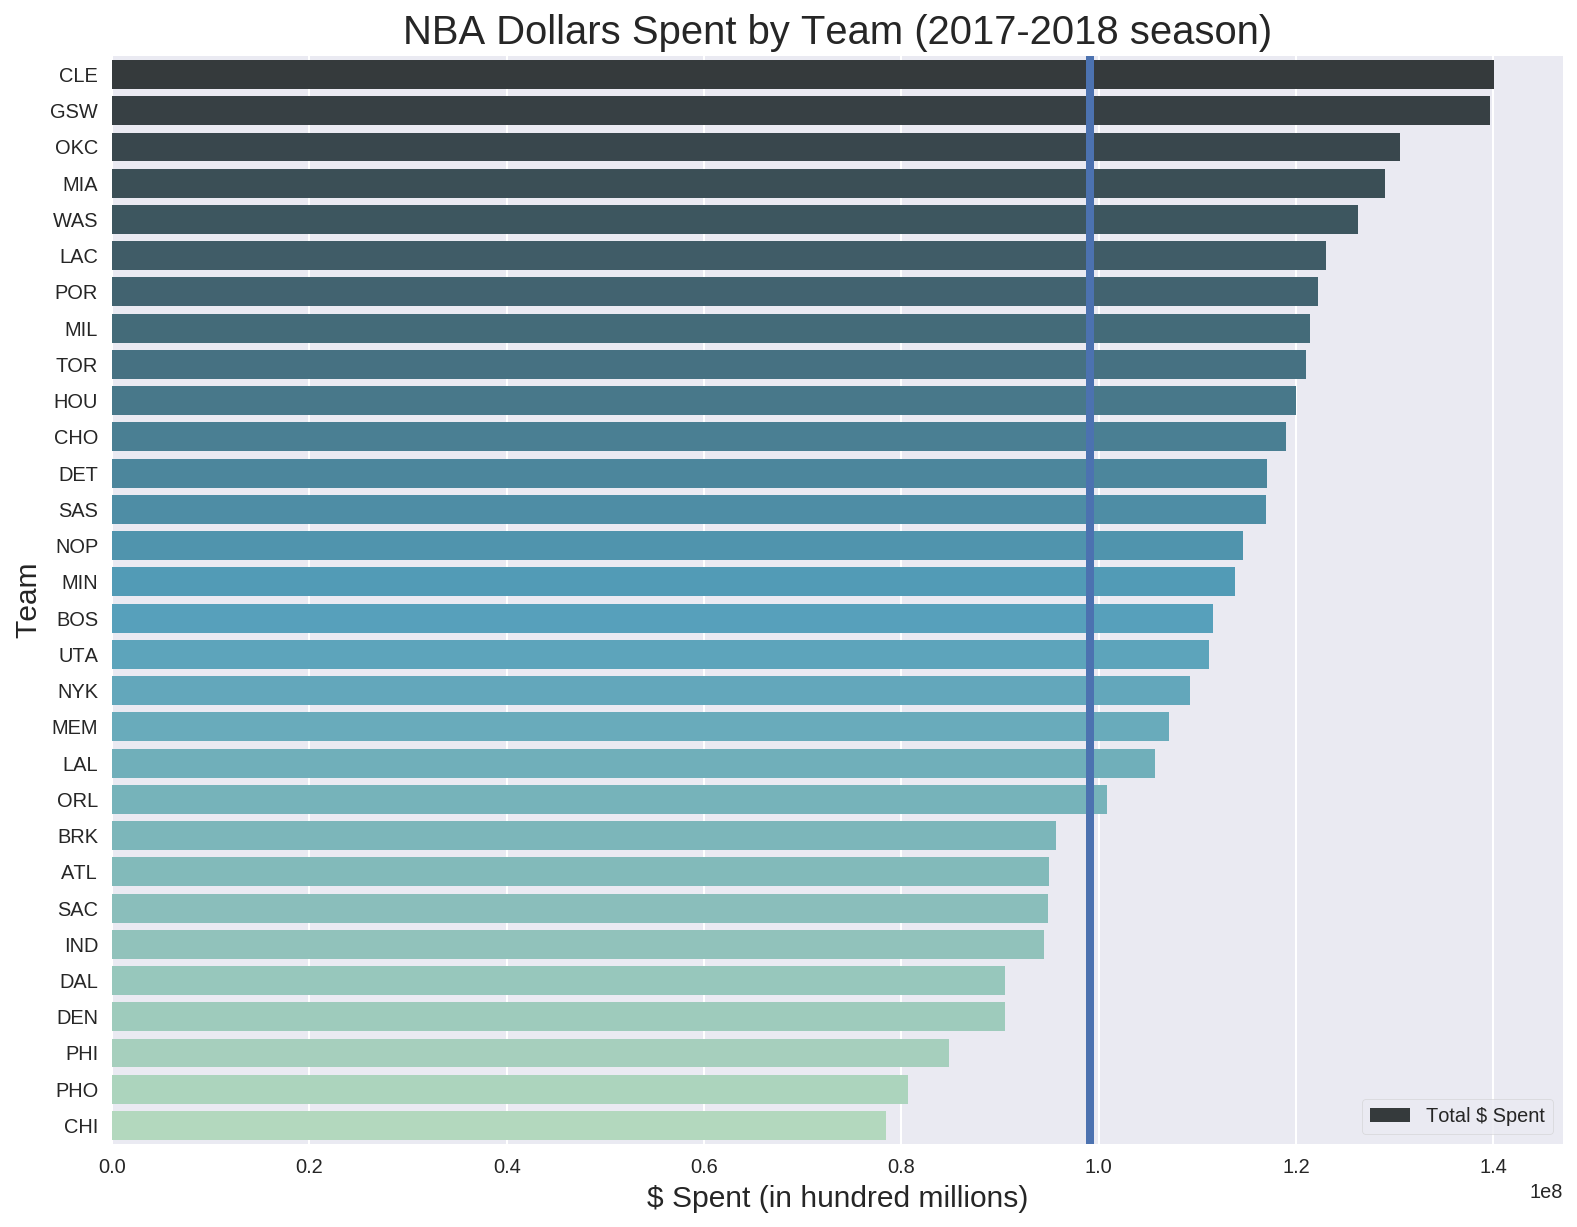

In [14]:
fig = plt.figure(figsize=(13,10)) 
ax = plt.gca()

sns.barplot(x='year_zero', y='team', data=team_total.sort_values('year_zero',ascending=False), label='Total $ Spent',palette='GnBu_d')

ax.legend(loc="lower right", frameon=True)
ax.set_title('NBA Dollars Spent by Team (2017-2018 season)',size=20)
ax.set_ylabel('Team', fontsize=15)
ax.set_xlabel('$ Spent (in hundred millions)', fontsize=15)

sns.despine(left=True, bottom=True)
plt.plot([99093000, 99093000], [100, -1], linewidth=4)
plt.show()

### EDA on Salary Spread

Not only has there been explosive growth in the amount money spent on NBA players, but there also seems to be a huge earnings gap for each individual players with clear outliers on the top. This seems to be the trend for every team. Developing a plot below to show this.

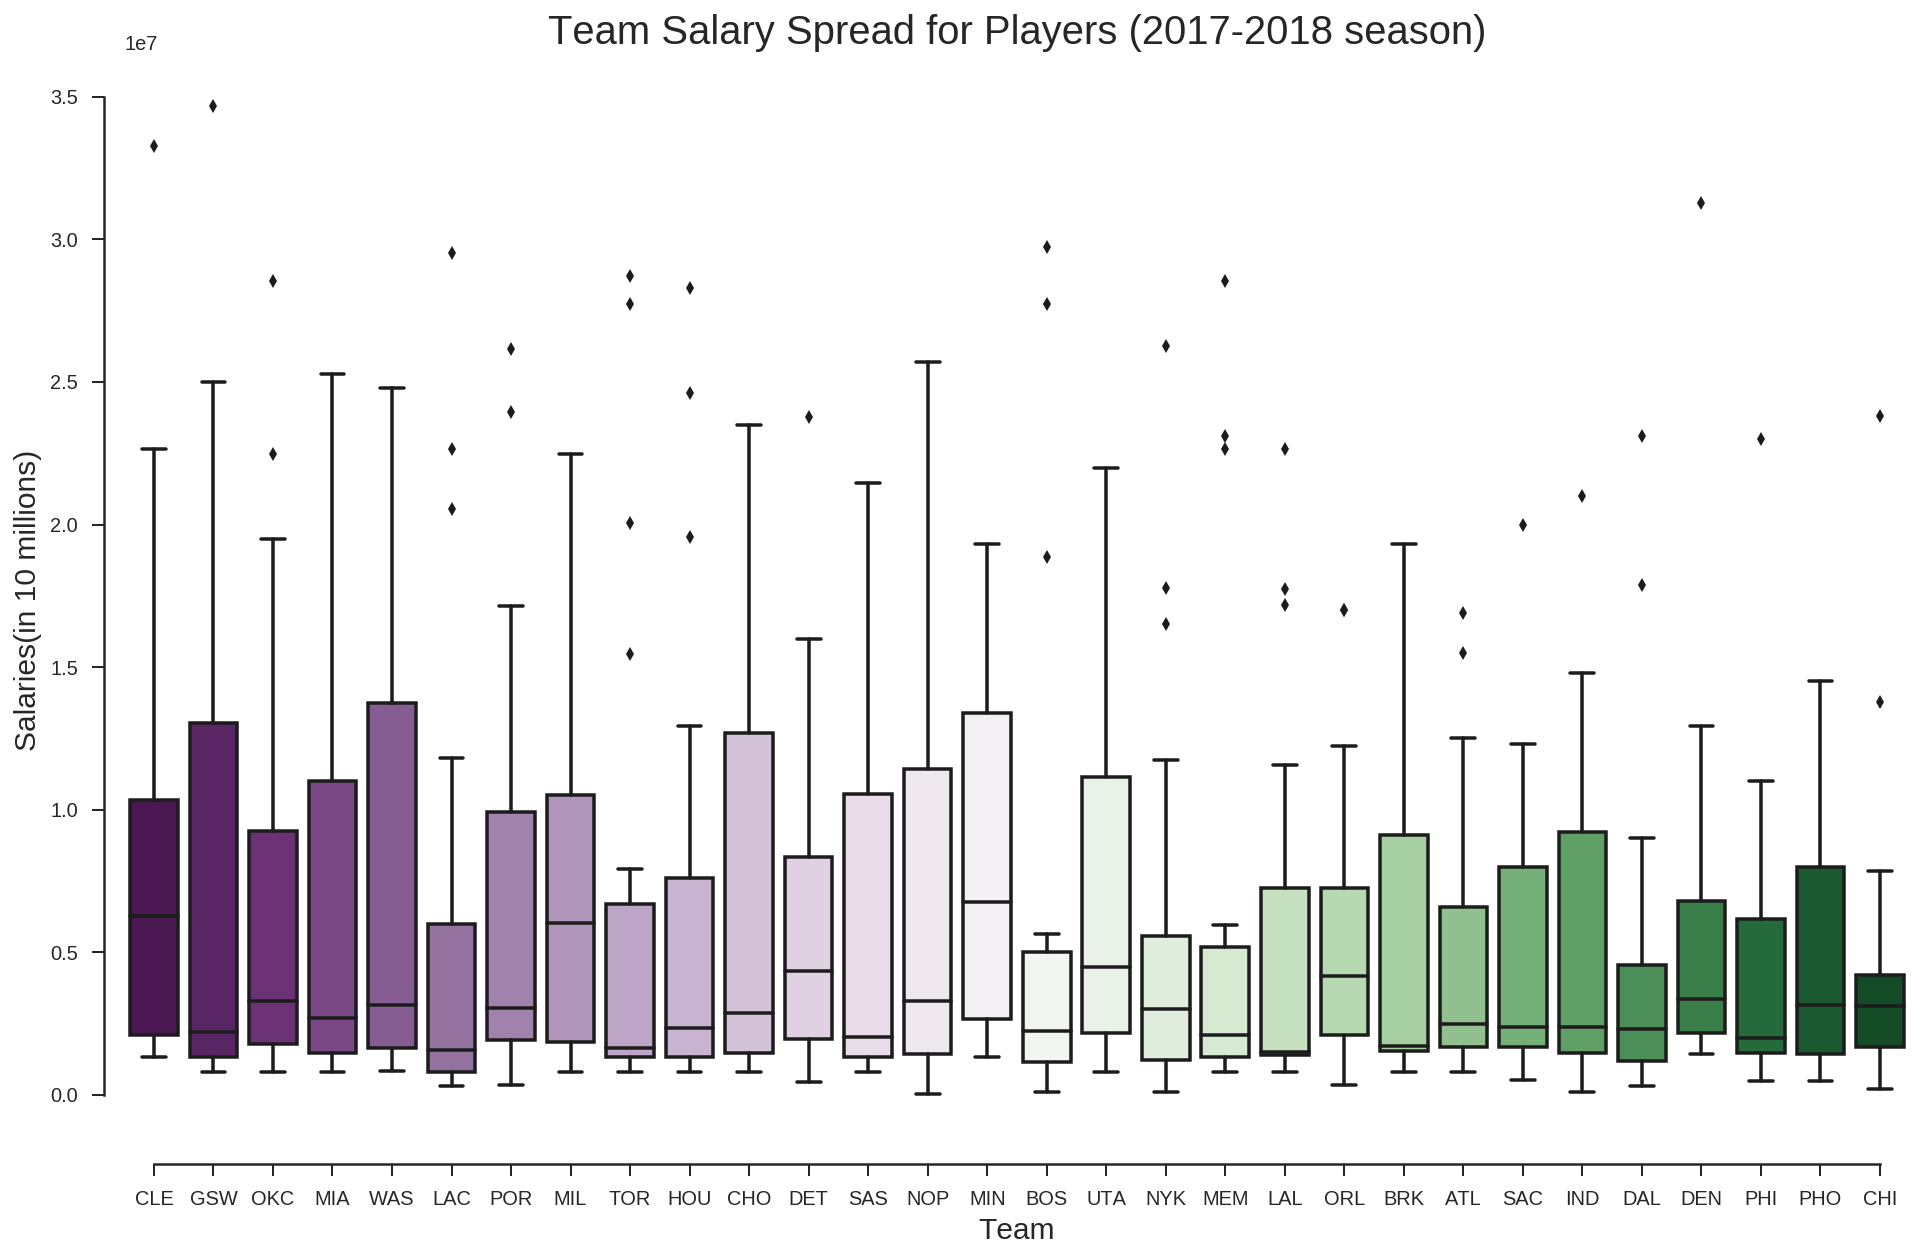

In [17]:
team_box = team_sal_df[['team','year_zero']]

fig = plt.figure(figsize=(16,10)) 
ax = plt.gca()

sns.set(style="ticks")
sns.boxplot(x="team", y="year_zero", data=team_box, palette="PRGn")

ax.set_title('Team Salary Spread for Players (2017-2018 season)',size=20)
ax.set_ylabel('Salaries(in 10 millions)', fontsize=15)
ax.set_xlabel('Team', fontsize=15)

sns.despine(offset=10, trim=True)

In [18]:
team_sal_df.describe()

,guaranteed,year_five,year_four,year_one,year_three,year_two,year_zero
count,5.140000e+02,5.140000e+02,5.140000e+02,5.140000e+02,5.140000e+02,5.140000e+02,5.140000e+02
mean,1.422262e+07,1.880959e+05,4.017553e+05,5.595186e+06,1.819963e+06,3.929540e+06,6.429708e+06
std,2.486012e+07,2.923282e+06,3.979132e+06,7.818813e+06,6.338897e+06,7.781787e+06,7.288537e+06
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.500000e+04
25%,1.471382e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.467286e+06
50%,3.565646e+06,0.000000e+00,0.000000e+00,1.810658e+06,0.000000e+00,0.000000e+00,2.925892e+06
75%,1.625238e+07,0.000000e+00,0.000000e+00,7.963403e+06,0.000000e+00,3.240000e+06,9.225694e+06
max,2.011588e+08,4.687200e+07,4.578097e+07,3.745715e+07,4.300636e+07,4.023176e+07,3.468255e+07


### EDA on 2016-2017 NBA player stats and salaries

Now let's start doing some exploratory data analysis on the main table for our model below. We saw a pretty wide spread from the box plot above. Let's take a look at the distribution of salaries last NBA season. It'll probably show a skew distribution with more players getting paid less.

In [19]:
nba_df = query_to_df('SELECT * FROM nba_2016')
nba_df.head()

,age,all_star,ast_per_g,blk_per_g,college,current_team,draft_position,draft_year,drb_per_g,efg_perc,...,three_att_per_g,three_per_g,three_perc,tov_per_g,trb_per_g,two_att_per_g,two_per_g,two_perc,weight_lbs,ws
0,24,0,0.6,0.1,no_college,Oklahoma City Thunder,32,2013,1.0,0.531,...,3.6,1.4,0.381,0.5,1.3,1.4,0.6,0.426,190.0,2.1
1,27,0,0.6,0.5,Baylor University,Brooklyn Nets,37,2012,2.8,0.542,...,2.6,1.1,0.434,0.6,3.3,2.2,0.9,0.414,240.0,0.9
2,24,0,1.1,1.0,no_college,Oklahoma City Thunder,12,2013,4.2,0.571,...,0.0,0.0,0.000,1.8,7.7,8.2,4.7,0.572,255.0,6.5
3,32,0,1.3,0.1,"University of California, Los Angeles",Orlando Magic,27,2007,1.9,0.514,...,2.5,1.0,0.411,0.7,2.0,4.4,2.0,0.457,210.0,1.4
4,29,0,0.3,0.6,no_college,New Orleans Pelicans,20,2008,3.4,0.500,...,0.1,0.0,0.000,0.8,4.5,4.5,2.3,0.511,248.0,1.0


In [21]:
nba_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 469 entries, 0 to 468
Data columns (total 42 columns):
age                469 non-null int64
all_star           469 non-null int64
ast_per_g          469 non-null float64
blk_per_g          469 non-null float64
college            469 non-null object
current_team       469 non-null object
draft_position     469 non-null int64
draft_year         469 non-null int64
drb_per_g          469 non-null float64
efg_perc           469 non-null float64
fg_per_g           469 non-null float64
fg_perc            469 non-null float64
fga_per_g          469 non-null float64
ft_per_g           469 non-null float64
ft_perc            469 non-null float64
fta_per_g          469 non-null float64
g                  469 non-null float64
gs                 469 non-null float64
height_inches      469 non-null float64
mp_per_g           469 non-null float64
orb_per_g          469 non-null float64
per                469 non-null float64
pf_per_g           469 no

We saw a pretty wide spread from the box plot above. Let's take a look at the distribution of salaries last NBA season. It'll probably show a skew distribution with more players getting paid less.

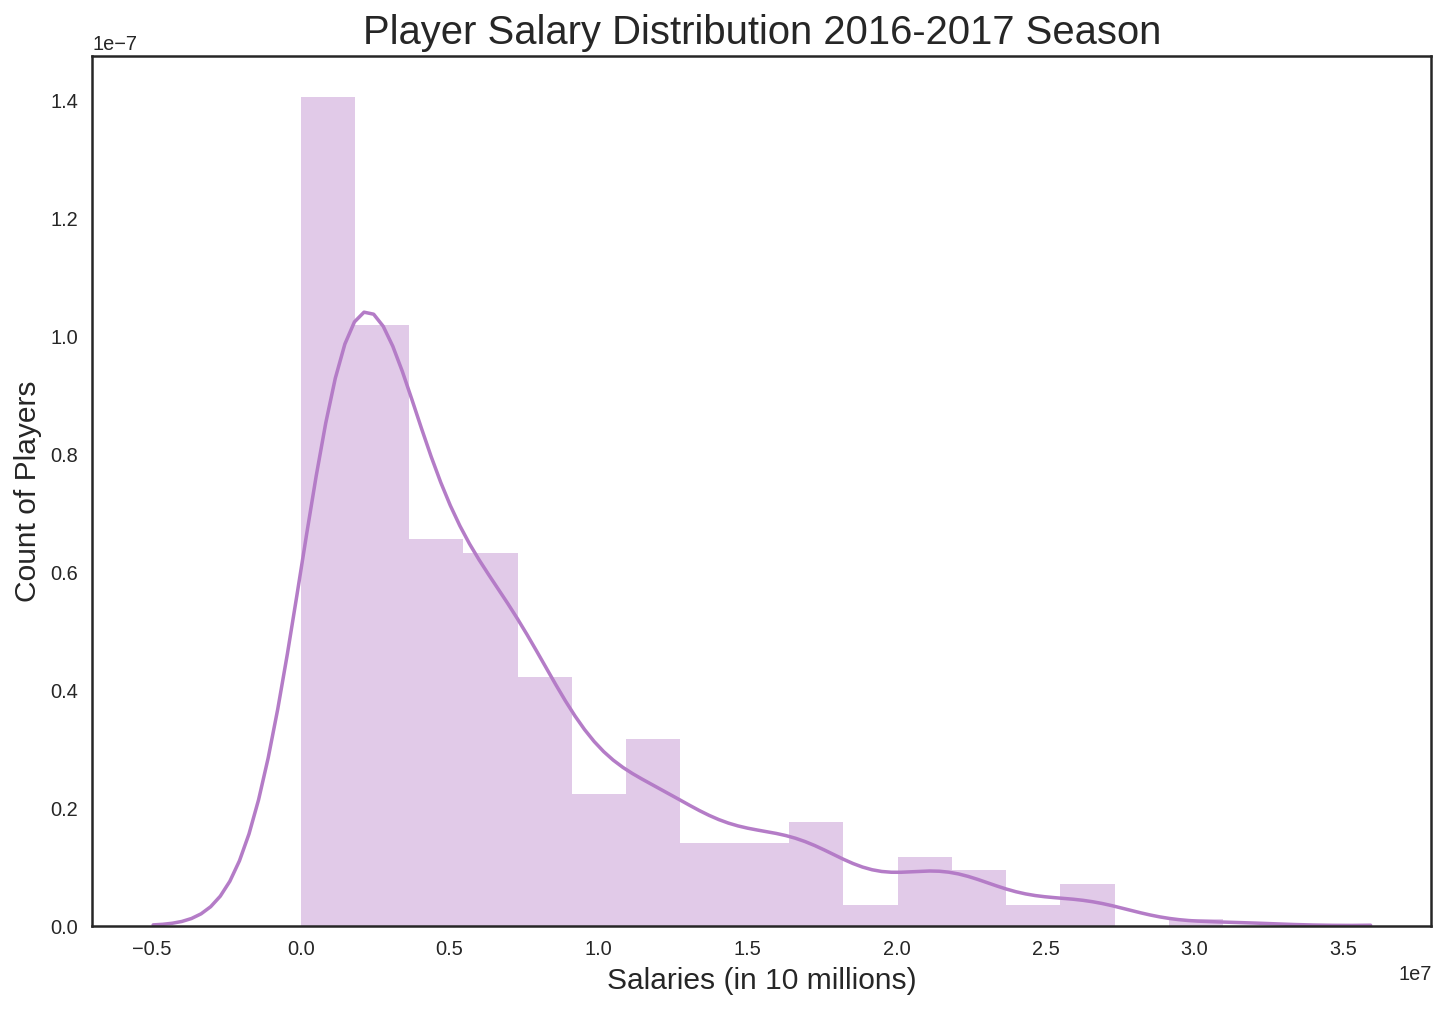

In [40]:
fig = plt.figure(figsize=(12,8)) 
ax = plt.gca()

sns.set(style="white", palette="muted", color_codes=True)
sns.distplot(nba_df['recent_salary'], color="m")

ax.set_title('Player Salary Distribution 2016-2017 Season',size=20)
ax.set_ylabel('Count of Players', fontsize=15)
ax.set_xlabel('Salaries (in 10 millions)', fontsize=15)
plt.show()

I'm wondering if a player's age has anything to do with their salaries. There is probably a peak somewhere in the middle range as player's in the prime of their physical performence will be beyond their rookie years but will be younger than players who are near retirement

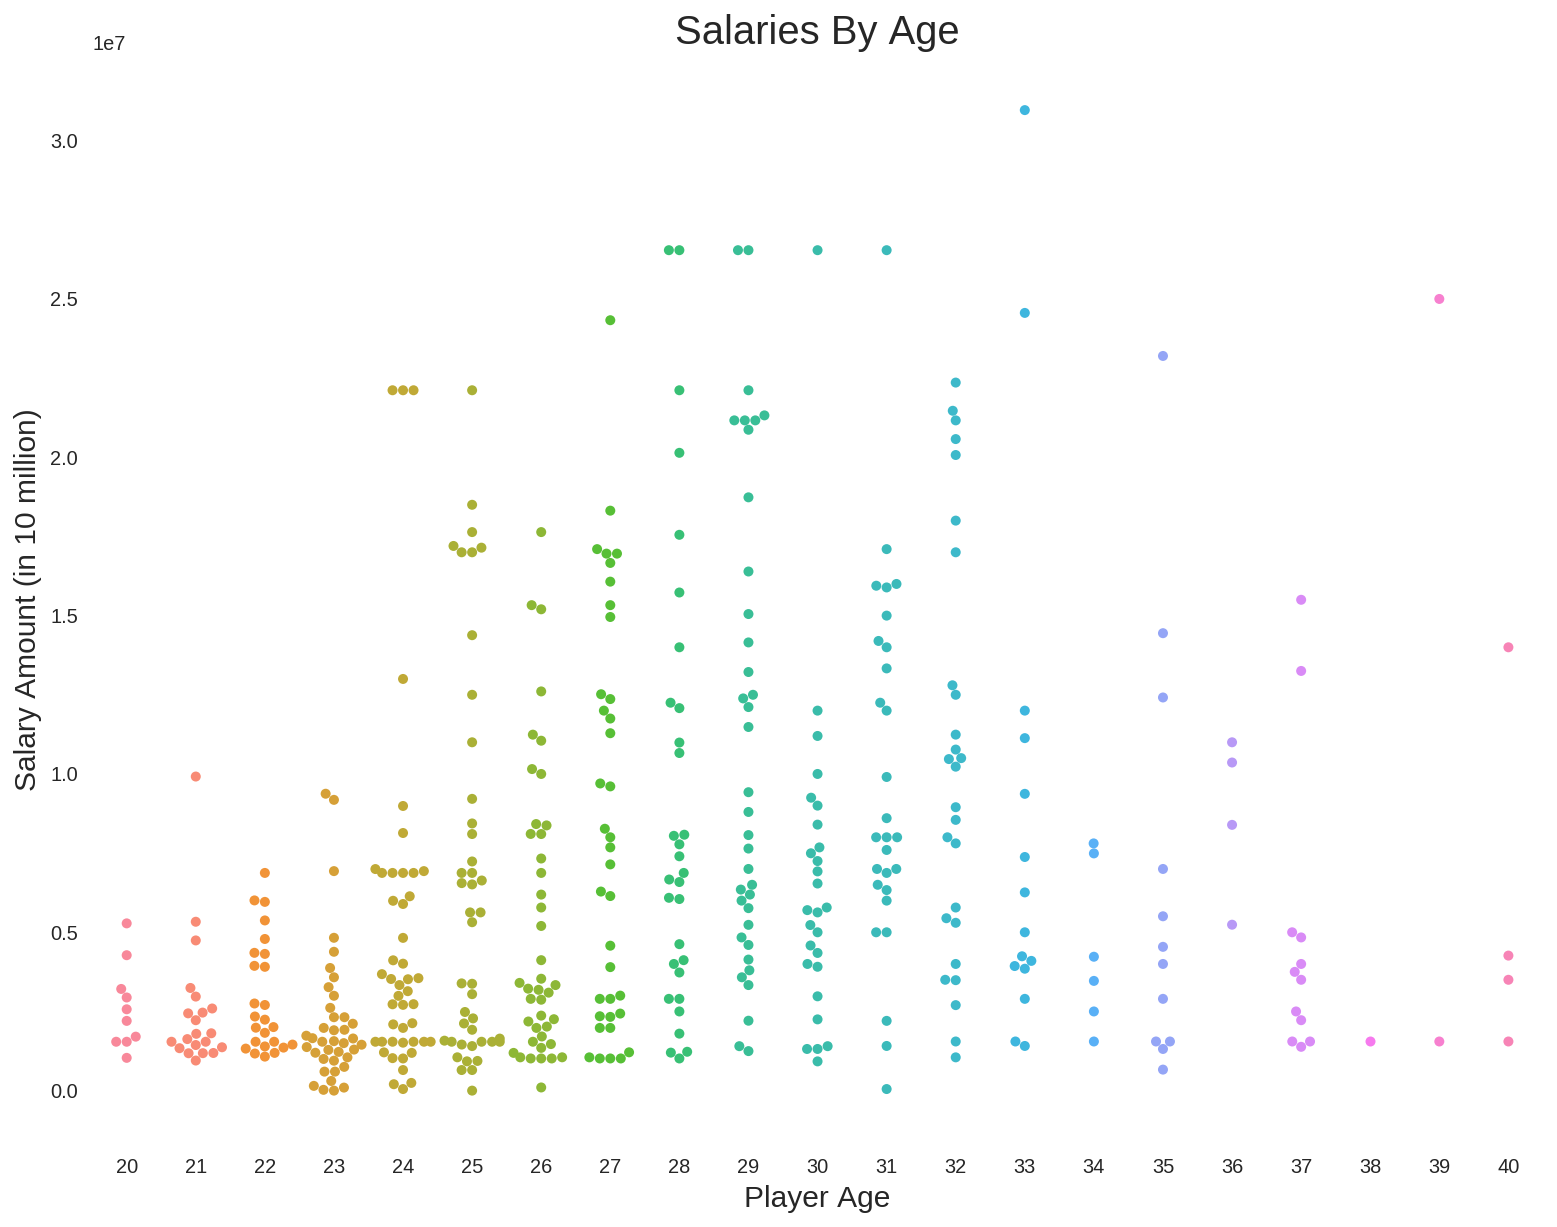

In [46]:
fig = plt.figure(figsize=(13,10)) 
ax = plt.gca()

sns.swarmplot(x='age', y='recent_salary', data=nba_df.sort_values('age',ascending=False))

ax.set_title('Salaries By Age',size=20)
ax.set_ylabel('Salary Amount (in 10 million)', fontsize=15)
ax.set_xlabel('Player Age', fontsize=15)

sns.despine(left=True, bottom=True)
plt.show()

That's kind of interesting. It looks like around the ages of 28-33 is when we see the really high salaries. It looks like there are large grouping of players who are much younger (in the 20-23 range) who have significantly lower salaries than the rest. I think this might be due to the fact younger players are more likely to be in their rookie contracts. Usually, players' salaries are are constrained by the rookie salary cap which is typically in force for three years - which is shown in that ages 20-23 had the lowest salaries.

Let's take a look at this based on season count.

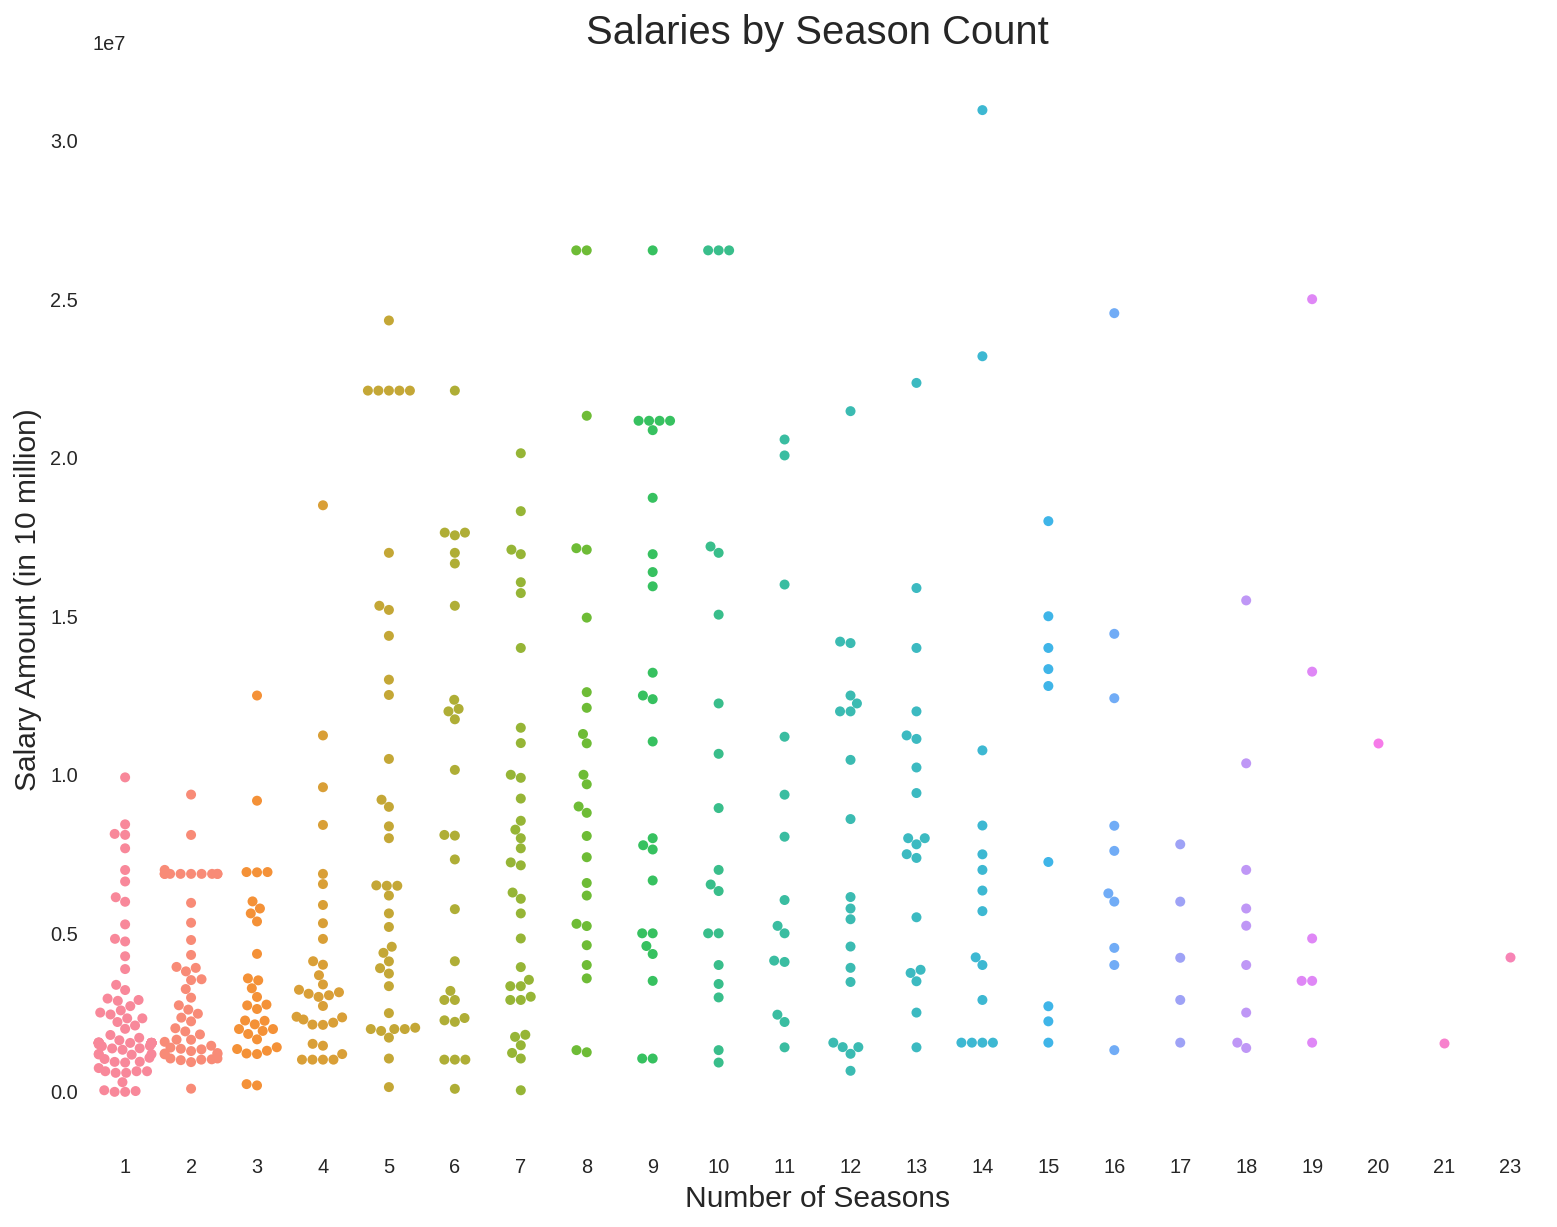

In [47]:
fig = plt.figure(figsize=(13,10)) 
ax = plt.gca()

sns.swarmplot(x='season_count', y='recent_salary', data=nba_df.sort_values('age',ascending=False))

ax.set_title('Salaries by Season Count',size=20)
ax.set_ylabel('Salary Amount (in 10 million)', fontsize=15)
ax.set_xlabel('Number of Seasons', fontsize=15)

sns.despine(left=True, bottom=True)
plt.show()

The swarm grew even larger at the first 3 year mark - it definitely seems that it's an affect of the rookie contract constraint.